In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

from tqdm import tqdm
import warnings
from pprint import pprint

In [226]:
data = pd.read_csv("./data/augmented_data.csv")

In [227]:
data.nunique()

period                     5
minute                   139
possession               290
duration               78059
play_pattern               9
position                  25
location_x               635
location_y               702
technique                  7
body_part                  4
type                       5
first_time                 2
open_goal                  2
one_on_one                 2
aerial_won                 2
follows_dribble            2
under_pressure             2
pass_duration          11912
pass_angle             10519
pass_type                  8
pass_height                4
pass_length             9930
num_passes                13
statsbomb_xg           82551
end_location_x           376
end_location_y           705
is_goal                    2
location_y_distance      472
shot_angle             52936
dtype: int64

In [228]:
data = data.drop(["location_y", "pass_height", "pass_type", "duration"], axis=1)

In [229]:
# one-hot encode the categorical data
encoded_data = data
for column_name in ["play_pattern", "position", "technique", "body_part", "type"]:
    one_hot_encoded = pd.get_dummies(encoded_data[column_name], prefix=column_name)
    encoded_data = encoded_data.drop(column_name, axis=1)
    encoded_data = pd.concat([encoded_data, one_hot_encoded], axis=1)
data = encoded_data

In [230]:
data.nunique()

period              5
minute            139
possession        290
location_x        635
first_time          2
                 ... 
type_Corner         2
type_Free Kick      2
type_Kick Off       2
type_Open Play      2
type_Penalty        2
Length: 70, dtype: int64

In [231]:
data = data.dropna()
data.replace([np.inf, -np.inf], 0, inplace=True)

In [232]:
y1 = data["statsbomb_xg"]
y2 = data["is_goal"]
X = data.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y"], axis=1)
position_columns = [col for col in data.columns if col.startswith("position")]
technique_columns = [col for col in data.columns if col.startswith("technique")]
X = X.drop(position_columns + technique_columns, axis=1)

In [233]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84065 entries, 0 to 84064
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   period                       84065 non-null  float64
 1   minute                       84065 non-null  float64
 2   possession                   84065 non-null  float64
 3   location_x                   84065 non-null  float64
 4   first_time                   84065 non-null  bool   
 5   open_goal                    84065 non-null  bool   
 6   one_on_one                   84065 non-null  bool   
 7   aerial_won                   84065 non-null  bool   
 8   follows_dribble              84065 non-null  bool   
 9   under_pressure               84065 non-null  bool   
 10  pass_duration                84065 non-null  float64
 11  pass_angle                   84065 non-null  float64
 12  pass_length                  84065 non-null  float64
 13  num_passes      

In [234]:
def preprocess_continuous(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    return X_train, X_test, y_train, y_test

In [235]:
def preprocess_classifier(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    X_train, y_train = SMOTE().fit_resample(X_train, y_train)

    return X_train, X_test, y_train, y_test

In [236]:
def calculate_errors(results_test, results_pred, name):
    mae = mean_absolute_error(results_test, results_pred)
    rmse = root_mean_squared_error(results_test, results_pred)
    r2 = r2_score(results_test, results_pred)
    print(f"\n{name}")
    print("Mean Absolute Error:", mae)
    print("Root Mean Squared Error:", rmse)
    print("R-squared (R2 Score):", r2)

In [237]:
def calculate_stats(results_test, results_pred, name):
    cm = confusion_matrix(results_test, results_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not a goal", "Goal"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    print(f"\n{name}")
    accuracy = accuracy_score(results_test, results_pred)
    precision = precision_score(results_test, results_pred)
    recall = recall_score(results_test, results_pred)
    f1 = f1_score(results_test, results_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)

In [238]:
def linear_regression():
    linear_r = LinearRegression()
    linear_r.fit(X_train, y_train)
    y_pred = linear_r.predict(X_test)

    calculate_errors(y_test, y_pred, "Linear Regression")

    print(pd.DataFrame(linear_r.coef_,
             X.columns,
             columns=['coef'])\
            .sort_values(by='coef', ascending=False))

    return y_pred

In [239]:
def logistic_regression():
    logistic_r = LogisticRegression()
    logistic_r.fit(X_train, y_train)
    y_pred = logistic_r.predict(X_test)

    calculate_stats(y_test, y_pred, "Logistic Regression")

    return logistic_r.predict_proba(X_test)

In [240]:
def decision_tree():
    dt = DecisionTreeClassifier(criterion="gini", max_depth=7, max_leaf_nodes=25, min_samples_split=2)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)

    calculate_stats(y_test, y_pred, "Decision Tree")

    return dt.predict_proba(X_test)

In [241]:
def gradient_boosted_tree():
    gbt = GradientBoostingClassifier(learning_rate=0.15, max_depth=10, min_samples_split=6, n_estimators=300, max_features=None)
    gbt.fit(X_train, y_train)
    y_pred = gbt.predict(X_test)

    calculate_stats(y_test, y_pred, "Gradient Boosted Tree")

    return gbt.predict_proba(X_test)

In [242]:
X_train, X_test, y_train, y_test = preprocess_continuous(X, y1)
lr_xg = linear_regression()


Linear Regression
Mean Absolute Error: 0.0527651845948159
Root Mean Squared Error: 0.08410896891548934
R-squared (R2 Score): 0.6860894911378287
                                     coef
play_pattern_Regular Play    5.587702e+09
play_pattern_From Free Kick  4.801223e+09
play_pattern_From Throw In   4.519847e+09
play_pattern_From Corner     4.344512e+09
play_pattern_From Counter    2.466506e+09
play_pattern_From Goal Kick  2.257795e+09
play_pattern_Other           1.504450e+09
play_pattern_From Keeper     1.457921e+09
play_pattern_From Kick Off   1.262624e+09
location_x                   5.503416e-02
open_goal                    4.738341e-02
one_on_one                   1.502602e-02
first_time                   4.805287e-03
possession                   3.872284e-03
pass_duration                2.014478e-03
follows_dribble              8.146997e-04
pass_angle                   7.839040e-04
shot_angle                   4.118650e-04
period                      -5.344328e-04
num_passes     

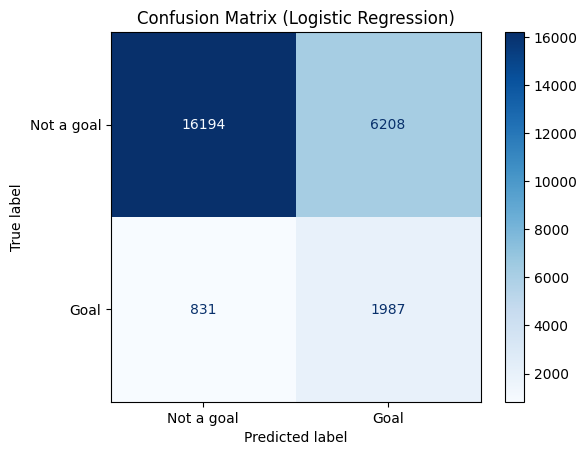


Logistic Regression
Accuracy: 0.7208961141950833
Precision: 0.24246491763270286
Recall: 0.705110007097232
F1: 0.3608462725869427


In [243]:
X_train, X_test, y_train, y_test = preprocess_classifier(X, y2)
lor_xg = logistic_regression()

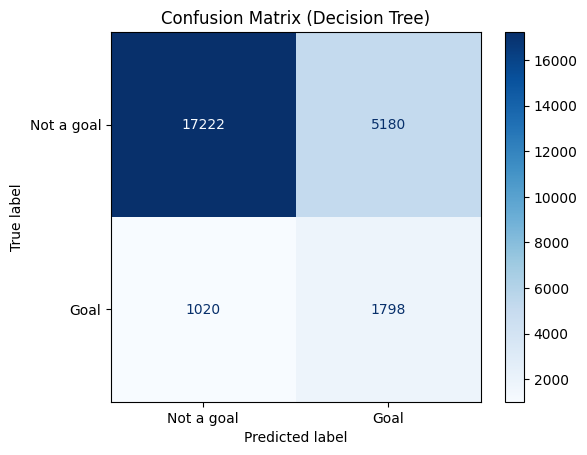


Decision Tree
Accuracy: 0.7541633624107851
Precision: 0.2576669532817426
Recall: 0.638041163946061
F1: 0.3670886075949367


In [244]:
dt_xg = decision_tree()

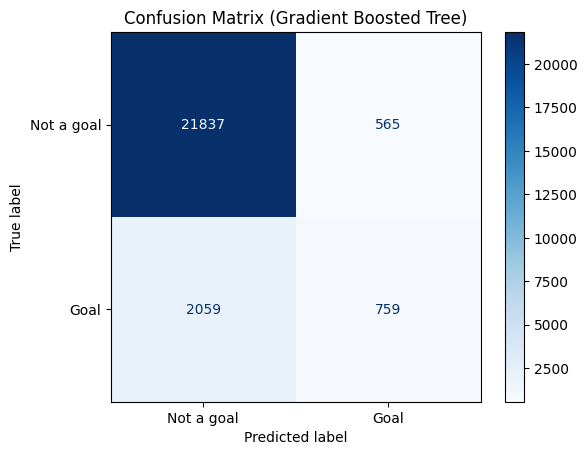


Gradient Boosted Tree
Accuracy: 0.8959555908009517
Precision: 0.573262839879154
Recall: 0.26933995741660754
F1: 0.36648961854176726


In [245]:
gbt_xg = gradient_boosted_tree()

In [246]:
_, _, _, sxg = preprocess_continuous(X, y1)
df = pd.DataFrame({"lr_xg": lr_xg, "lor_xg": [x[1] for x in lor_xg], "dt_xg": [x[1] for x in dt_xg], "gbt_xg": [x[1] for x in gbt_xg], "sxg": sxg})
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["lr_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["lor_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["dt_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["gbt_xg"]), np.asarray(df["sxg"]))))

          0         1
0  1.000000  0.828343
1  0.828343  1.000000
          0         1
0  1.000000  0.700346
1  0.700346  1.000000
          0         1
0  1.000000  0.654426
1  0.654426  1.000000
         0        1
0  1.00000  0.72973
1  0.72973  1.00000
